In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

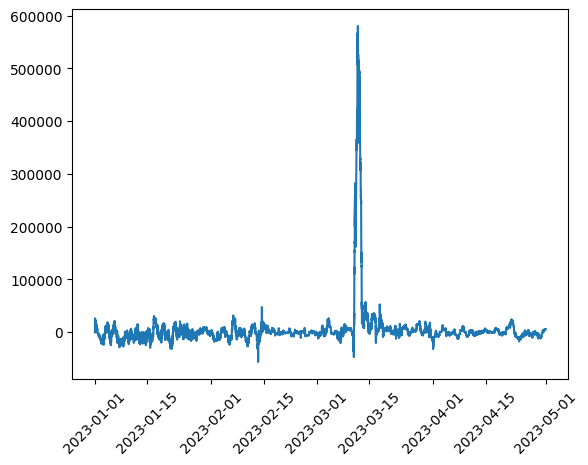

In [27]:
f, ax = plt.subplots()

roller = pool_metrics['USDC.netSwapFlow'].rolling('1d').mean()
ax.plot(roller.index, roller)

ax.tick_params(axis='x', rotation=45)


In [4]:
start = datetime.timestamp(datetime(2023, 3, 1))
end = datetime.timestamp(datetime(2023, 3, 15))

swaps_data = datahandler.get_swaps_data(pool, start, end)

tokens = set(swaps_data['tokenBought'])
ohlcvs = {}
ignore = ['0x6c3f90f043a72fa612cbac8115ee7e52bde6e490'] # metapool, ignore LP token for now
for token in tokens:
    if token in ignore:
        continue
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start, end)

In [136]:
def round_date(x):
    mydate = datetime.fromtimestamp(x)
    rounded_minute = mydate.minute + round(mydate.second/60)
    minute_difference = rounded_minute - mydate.minute
    mydate = mydate.replace(second=0) + timedelta(minutes=minute_difference)
    return mydate

def markout(df, ohlcvs, window=timedelta(days=1)):
    """
    markout price = price at t0 + window
    current price = price at t0
    execution price = converts token sold to token bought units
    """
    df['executionPrice'] = df['amountBought'] / df['amountSold']
    df['roundedDate'] = df['timestamp'].apply(round_date)
    last = df['roundedDate'].iloc[-1]
    df = df[df['roundedDate'] <= last - window]
    df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
    df['currentSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate']]['close'], axis=1)
    df['markout'] = df['amountSold'] * (df['executionPrice'] * df['markoutBoughtPrice'] - df['currentSoldPrice'])
    return df

def markout_inv(df, ohlcvs, window=timedelta(days=1)):
    """
    markout price = price at t0 + window
    current price = price at t0
    execution price = converts token bought to token sold units

    Just to check they give the same answer, they do!
    """
    df['executionPrice'] = df['amountSold'] / df['amountBought']
    df['roundedDate'] = df['timestamp'].apply(round_date)
    last = df['roundedDate'].iloc[-1]
    df = df[df['roundedDate'] <= last - window]
    df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
    df['currentSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate']]['close'], axis=1)
    df['markout'] = df['amountBought'] * (df['markoutBoughtPrice'] - df['executionPrice'] * df['currentSoldPrice'])
    return df

In [137]:
window = timedelta(days=1)
df = swaps_data.copy()
df = markout(df, ohlcvs, window=window)
df = df.set_index('roundedDate')
df['tokenBought'] = df['tokenBought'].apply(lambda x: token_metadata[x]['symbol'])
df['tokenSold'] = df['tokenSold'].apply(lambda x: token_metadata[x]['symbol'])
df = df[['tokenBought', 'tokenSold', 'amountBought', 'amountSold', 'markout', 'executionPrice', 'markoutBoughtPrice', 'currentSoldPrice']]
df.head()

/tmp/ipykernel_237189/972586276.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
/tmp/ipykernel_237189/972586276.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['currentSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate']]['close'], axis=1)
/tmp/ipykernel_237189/972586276.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,tokenBought,tokenSold,amountBought,amountSold,markout,executionPrice,markoutBoughtPrice,currentSoldPrice
roundedDate,,,,,,,,
2023-03-01 00:06:00,DAI,USDC,15088.179688,15090.0,1.197506,0.999879,1.0001,0.9999
2023-03-01 00:07:00,USDT,USDC,4998.884527,5000.0,0.384304,0.999777,1.0002,0.9999
2023-03-01 00:14:00,DAI,USDC,29946.385193,29950.0,-0.620169,0.999879,1.0001,1.0000
2023-03-01 00:24:00,DAI,USDC,4959.400905,4960.0,-0.103155,0.999879,1.0001,1.0000
2023-03-01 00:24:00,DAI,USDC,24197.075162,24200.0,-0.505130,0.999879,1.0001,1.0000


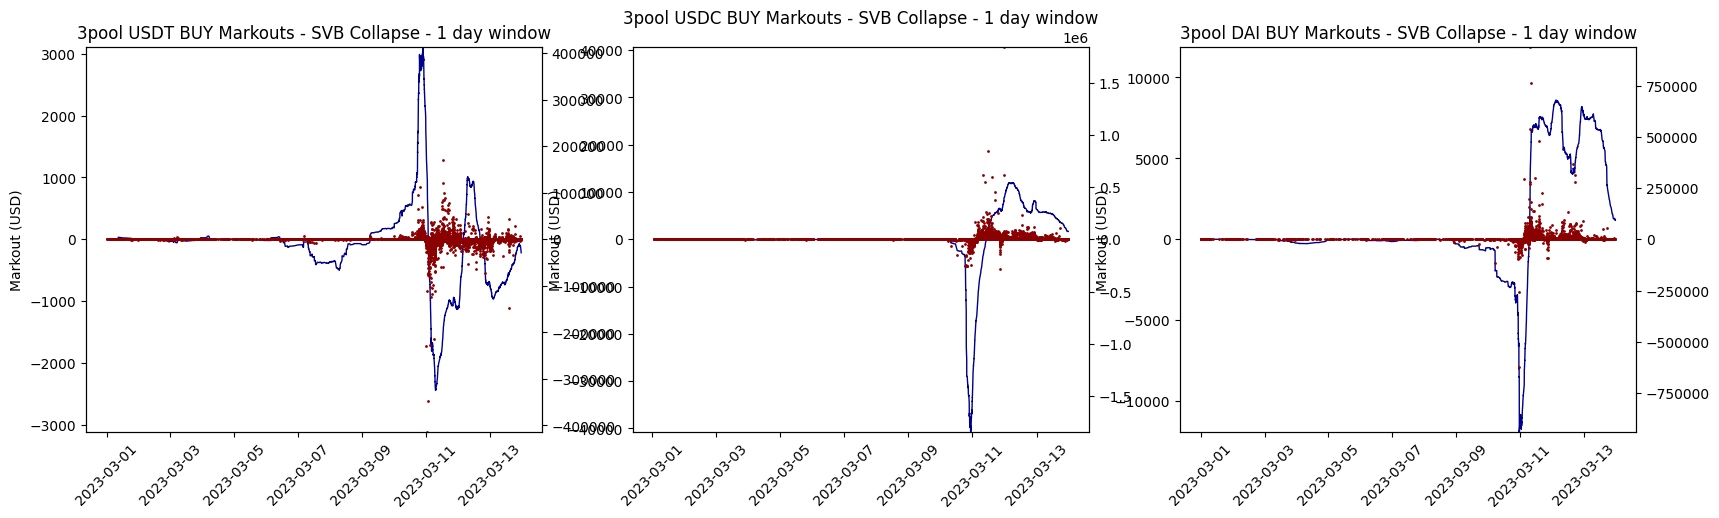

In [138]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenBought'] == symbol]
    rolling_markouts = ndf['markout'].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.scatter(ndf.index, ndf['markout'], s=1, c='darkred')
    axs[i].set_title(f'3pool {symbol} BUY Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')
    axlim = max(abs(rolling_markouts))
    axs[i].set_ylim(-axlim, axlim)
    axlim2 = max(abs(ndf['markout']))
    ax2.set_ylim(-axlim2, axlim2)

plt.show()

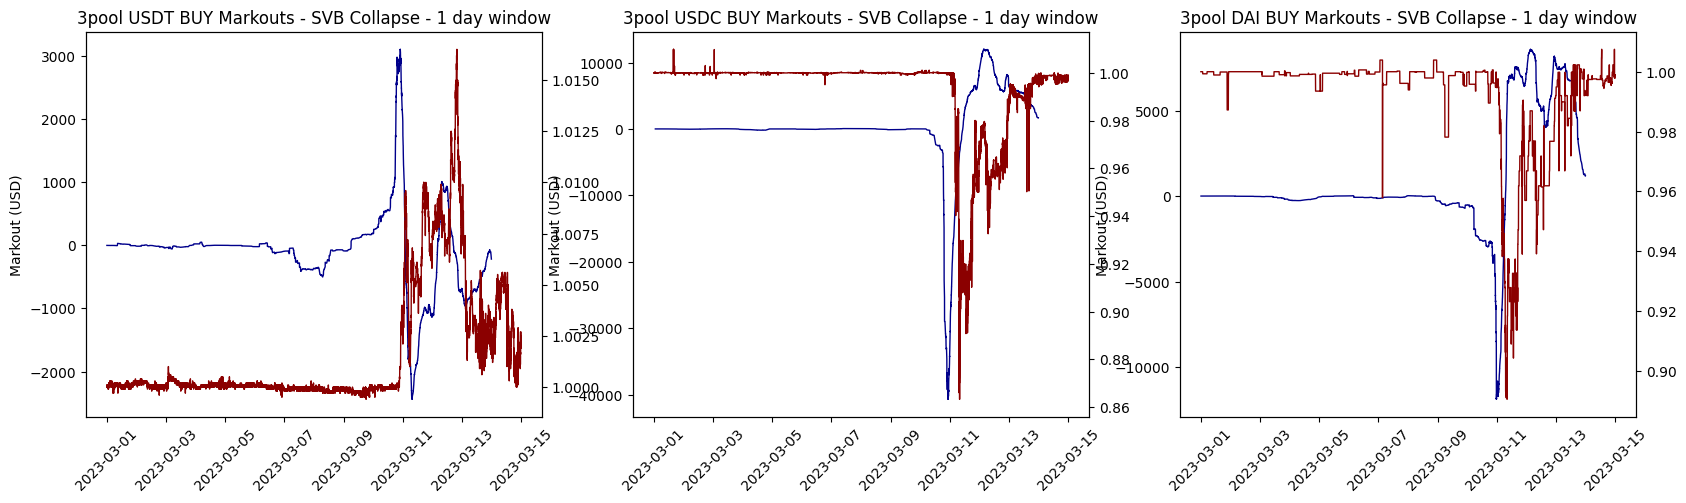

In [63]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenBought'] == symbol]
    rolling_markouts = ndf['markout'].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkred', linewidth=1)
    axs[i].set_title(f'3pool {symbol} BUY Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

plt.show()

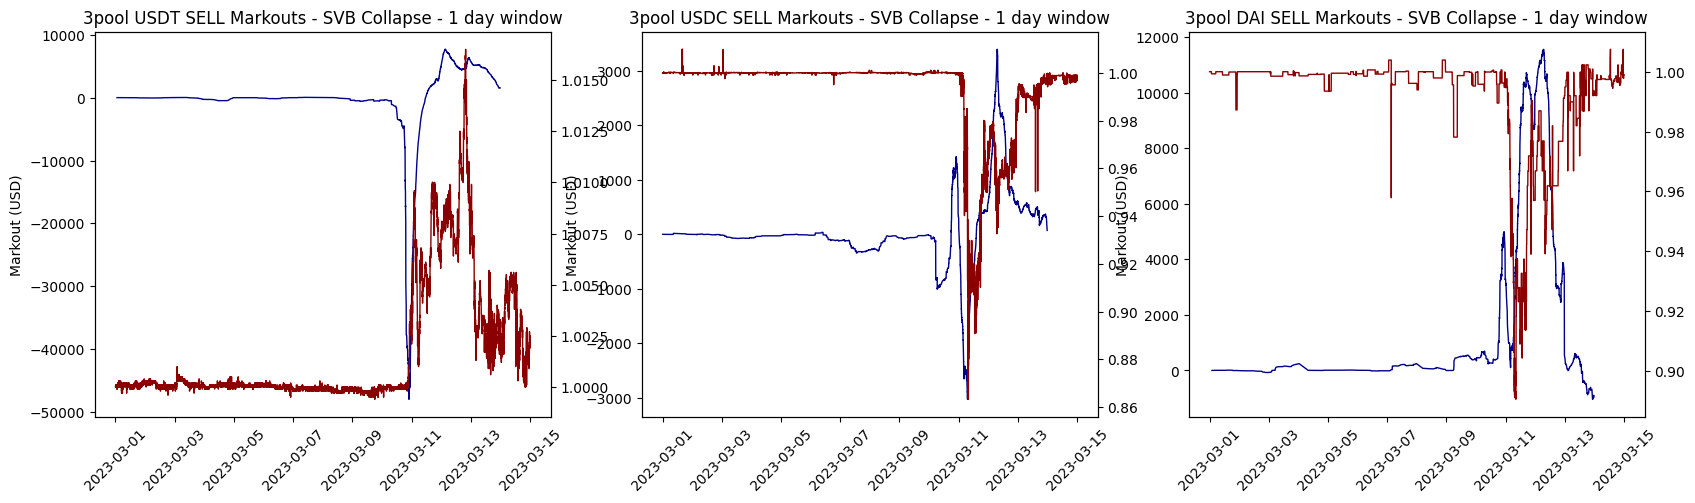

In [65]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenSold'] == symbol]
    rolling_markouts = ndf['markout'].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkred', linewidth=1)
    axs[i].set_title(f'3pool {symbol} SELL Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

plt.show()

In [66]:
window = timedelta(hours=1)
df = swaps_data.copy()
df = markout(df, ohlcvs, window=window)
df = df.set_index('roundedDate')
df['tokenBought'] = df['tokenBought'].apply(lambda x: token_metadata[x]['symbol'])
df['tokenSold'] = df['tokenSold'].apply(lambda x: token_metadata[x]['symbol'])
df = df[['tokenBought', 'tokenSold', 'amountBought', 'amountSold', 'markout', 'executionPrice', 'markoutBoughtPrice', 'currentSoldPrice']]

/tmp/ipykernel_237189/2343968623.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
/tmp/ipykernel_237189/2343968623.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['currentSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate']]['close'], axis=1)
/tmp/ipykernel_237189/2343968623.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

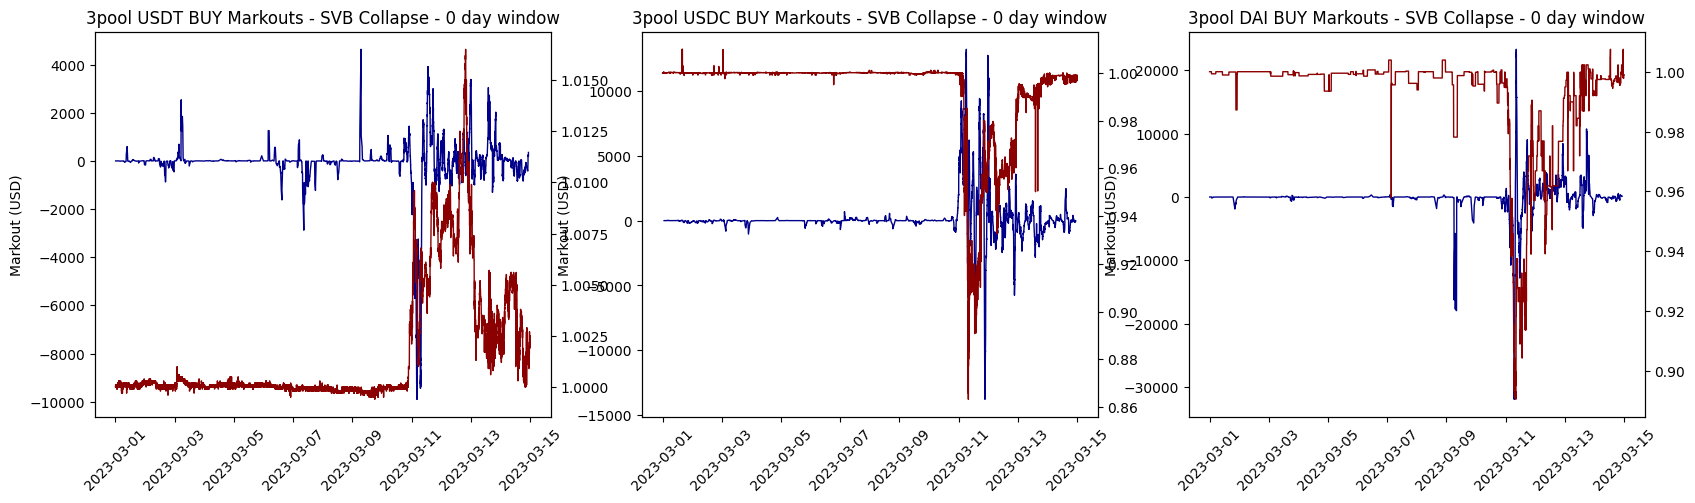

In [73]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenBought'] == symbol]
    rolling_markouts = ndf['markout'].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkred', linewidth=1)
    axs[i].set_title(f'3pool {symbol} BUY Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

plt.show()

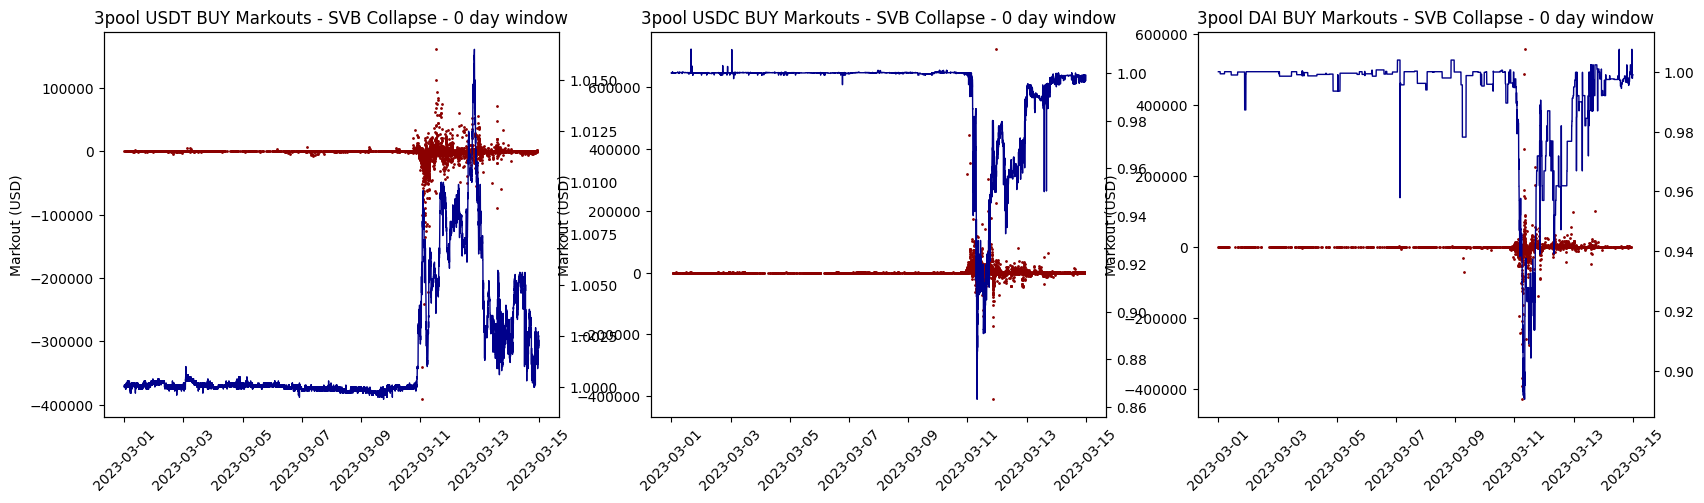

In [72]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenBought'] == symbol]
    rolling_markouts = ndf['markout'].rolling(window).mean()
    ax2 = axs[i].twinx()
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkblue', linewidth=1)
    axs[i].scatter(ndf.index, ndf['markout'], s=1, c='darkred')
    axs[i].set_title(f'3pool {symbol} BUY Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

plt.show()

KeyError: 'markout'

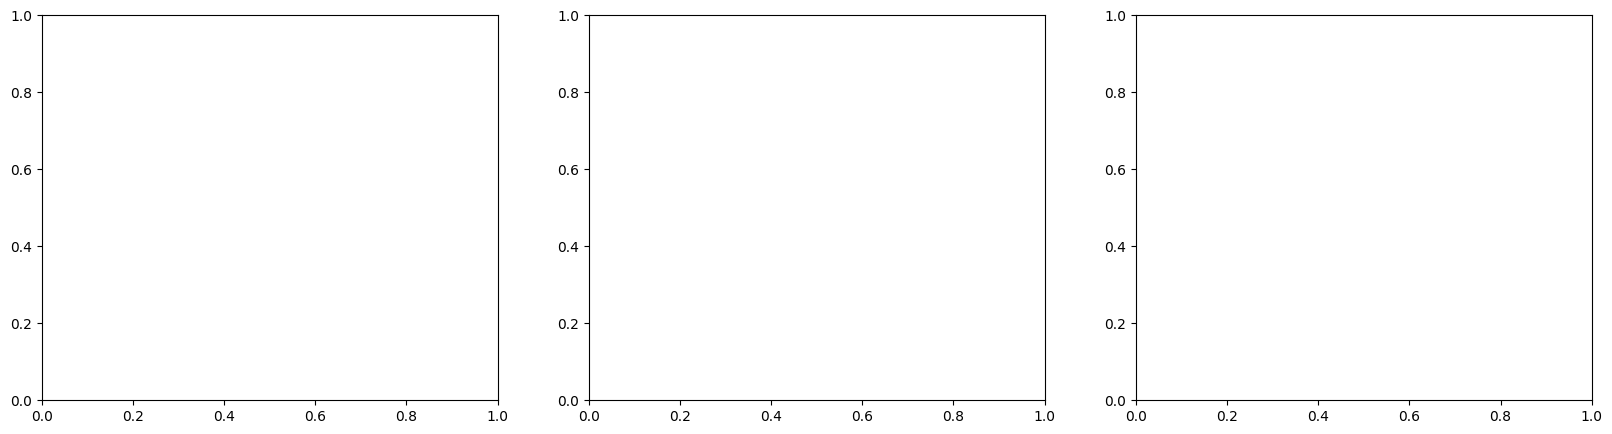

In [135]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenSold'] == symbol]
    rolling_markouts = ndf['markout'].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkred', linewidth=1)
    axs[i].set_title(f'3pool {symbol} SELL Markouts - SVB Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

plt.show()

<Axes: xlabel='timestamp'>

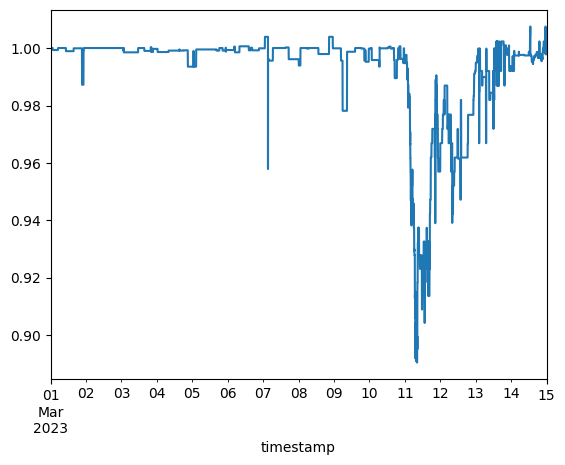

In [23]:
usdt = '0xdac17f958d2ee523a2206206994597c13d831ec7'
usdc = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
dai = '0x6b175474e89094c44da98b954eedeac495271d0f'
ohlcvs[dai]['close'].plot()

In [31]:
window = timedelta(days=1)
df_inv = swaps_data.copy()
df_inv = markout_inv(df_inv, ohlcvs, window=window)
df_inv = df_inv.set_index('roundedDate')
df_inv['tokenBought'] = df_inv['tokenBought'].apply(lambda x: token_metadata[x]['symbol'])
df_inv['tokenSold'] = df_inv['tokenSold'].apply(lambda x: token_metadata[x]['symbol'])
df_inv = df_inv[['tokenBought', 'tokenSold', 'amountBought', 'amountSold', 'markout', 'executionPrice', 'markoutBoughtPrice', 'currentSoldPrice']]
df_inv.head()

,tokenBought,tokenSold,amountBought,amountSold,markout,executionPrice,markoutBoughtPrice,currentSoldPrice
roundedDate,,,,,,,,
2023-03-01 00:06:00,DAI,USDC,15088.179688,15090.0,1.197506,1.000121,1.0001,0.9999
2023-03-01 00:07:00,USDT,USDC,4998.884527,5000.0,0.384304,1.000223,1.0002,0.9999
2023-03-01 00:14:00,DAI,USDC,29946.385193,29950.0,-0.620169,1.000121,1.0001,1.0000
2023-03-01 00:24:00,DAI,USDC,4959.400905,4960.0,-0.103155,1.000121,1.0001,1.0000
2023-03-01 00:24:00,DAI,USDC,24197.075162,24200.0,-0.505130,1.000121,1.0001,1.0000


In [45]:
df[~(abs(df['markout'] - df_inv['markout']) < 1e-5)]

,tokenBought,tokenSold,amountBought,amountSold,markout,executionPrice,markoutBoughtPrice,currentSoldPrice
roundedDate,,,,,,,,
2023-03-07 23:46:00,USDT,USDC,0.0,0.0,NaN,NaN,0.9998,1.0001
2023-03-12 00:50:00,USDC,USDT,0.0,0.0,NaN,NaN,0.9942,1.0076


In [46]:
df_inv[~(abs(df['markout'] - df_inv['markout']) < 1e-5)]

,tokenBought,tokenSold,amountBought,amountSold,markout,executionPrice,markoutBoughtPrice,currentSoldPrice
roundedDate,,,,,,,,
2023-03-07 23:46:00,USDT,USDC,0.0,0.0,NaN,NaN,0.9998,1.0001
2023-03-12 00:50:00,USDC,USDT,0.0,0.0,NaN,NaN,0.9942,1.0076
